# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.style as style
import os
import geopandas as gpd
import geoplot
import mapclassify
from tensorflow.keras.utils import get_file
from scipy import optimize
style.use('default')

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [2]:
df = pd.read_excel('../data/HIST_PAINEL_COVIDBR_07jul2020.xlsx')
data_inicial_base = df['data'].min()

### delimitar data anterior

#data_final_base = pd.to_datetime('2020-06-23', format='%Y-%m-%d' )
#fltr = df['data'] <= data_final_base
#df = df.loc[fltr, :]

### 

print(df.shape)
data_final_base = df['data'].max()
print('dados do dia {} ao dia {}'.format(data_inicial_base, data_final_base))
# tratamento inicial dos valores de população
df['populacaoTCU2019'] = df['populacaoTCU2019'].fillna('0')
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.split(pat='(', expand=True )
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','').astype(int)

(562012, 17)
dados do dia 2020-02-25 00:00:00 ao dia 2020-07-07 00:00:00


In [3]:
df_bolet = pd.read_excel('../data/dados_dourados_secmunsaude_sms_jun.xlsx')

### Dias de semana como varíável categórica 

In [4]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

In [5]:
uf_list= [ 'MS', 'AM']
Muni_list = ['Dourados', 'Manaus']


In [6]:
pathfigs = './figs/'

## Entre com as silgas dos estados e o nome das cidades para comparar

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [7]:
def preproc_comp_cidades(df1,estados, cidades):
    df1.sort_values('data', inplace = True)
    listDFs = []
    for i in range(len(estados)):
        # filtrando por estado
        fltr = df1['estado'].str.lower() == estados[i].lower()
        df_UF = df1.loc[fltr, :]
        # filtrando pro cidade
        fltr = df_UF['municipio'].str.lower() == cidades[i].lower()
        df_muni = df_UF.loc[fltr, :]

        ###
        #estado
        df_UF.dropna(subset=['municipio'])
        # esrado por município
        df_UF_muni = df_UF.groupby('municipio')
         # população do estado somatório dos municípios
        agg_estado = df_UF_muni.agg({'populacaoTCU2019': 'max', 'casosAcumulado': 'max'}).reset_index()
        popu_estado = agg_estado['populacaoTCU2019'].sum()
        casos_estado = agg_estado['casosAcumulado'].sum()
        
        df_UF_muni = df_UF_muni.agg({'populacaoTCU2019': 'max', 'casosAcumulado': 'max', 'obitosAcumulado': 'max',  }).reset_index()
        # estado por município, valores por 100 mil habitantes
        df_UF_muni['CA_por_cemMil_Hab'] = df_UF_muni['casosAcumulado'] * 10**5 / df_UF_muni['populacaoTCU2019']
        df_UF_muni['OA_por_cemMil_Hab'] = df_UF_muni['obitosAcumulado'] * 10**5 / df_UF_muni['populacaoTCU2019']
        df_UF_muni['CA_cemMil_log'] = df_UF_muni['CA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_UF_muni['OA_cemMil_log'] = df_UF_muni['OA_por_cemMil_Hab'].apply(lambda x: np.log10(x))

       
        print('População: somatório dos municípios do estado {} : {} '.format(estados[i], popu_estado))
        print('Casos: somatório dos municípios do estado {} : {} '.format(estados[i], casos_estado))
        print('Casos por cem mil habintnates do estado {} : {} '.format(estados[i], casos_estado*10**5/popu_estado))

        # totalização dos casos do estado
        df_UF = df_UF.groupby('data')
        df_UF = df_UF.agg({'casosNovos': sum, 'obitosNovos': sum, 'casosAcumulado': sum, 'obitosAcumulado': sum,'populacaoTCU2019': 'max'}).reset_index()
        df_UF['CN_por_cemMil_Hab'] = df_UF['casosNovos'] * 10**5 / popu_estado
        df_UF['ON_por_cemMil_Hab'] = df_UF['obitosNovos'] * 10**5 / popu_estado
        df_UF['CA_por_cemMil_Hab'] = df_UF['casosAcumulado'] * 10**5 / popu_estado
        df_UF['OA_por_cemMil_Hab'] = df_UF['obitosAcumulado'] * 10**5 / popu_estado

        ## dias a partir da primeira notificação
        dia_0 = df_UF['data'].min()
        df_UF['dia_num'] = (df_UF['data'] - dia_0).apply(lambda x: x.days)
        
        ###
        #cidades

        print('população da cidade de {}: {}'.format(cidades[i], df_muni['populacaoTCU2019'].max() ))
        df_muni['CN_por_cemMil_Hab'] = df_muni['casosNovos'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['ON_por_cemMil_Hab'] = df_muni['obitosNovos'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['CA_por_cemMil_Hab'] = df_muni['casosAcumulado'] * 10**5 / df_muni['populacaoTCU2019']
        df_muni['OA_por_cemMil_Hab'] = df_muni['obitosAcumulado'] * 10**5 / df_muni['populacaoTCU2019']

        # escala logarítimica
        df_muni['CN_cemMil_log'] = df_muni['CN_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['ON_cemMil_log'] = df_muni['ON_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['CA_cemMil_log'] = df_muni['CA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        df_muni['OA_cemMil_log'] = df_muni['OA_por_cemMil_Hab'].apply(lambda x: np.log10(x))
        ## dias a partir da primeira notificação
        dia_0 = df_muni['data'].min()
        df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)

        #lista de saida
        listDFs.append(df_UF)
        listDFs.append(df_UF_muni)
        listDFs.append(df_muni)
           
    return listDFs

In [8]:
df_est1, df_est1_muni, df_cidade1, df_est2, df_est2_muni, df_cidade2 = preproc_comp_cidades(df, uf_list, Muni_list)

População: somatório dos municípios do estado MS : 2723958 
Casos: somatório dos municípios do estado MS : 10694 
Casos por cem mil habintnates do estado MS : 392.5904878122203 
população da cidade de Dourados: 222949
População: somatório dos municípios do estado AM : 4144597 
Casos: somatório dos municípios do estado AM : 79639 
Casos por cem mil habintnates do estado AM : 1921.5137201518025 
população da cidade de Manaus: 2182763


In [47]:

def comp_cidades(cidade1, cidade2, pathfigs = './figs/'):
    cidade1.sort_values('data', inplace = True)
    cidade2.sort_values('data', inplace = True)
    cidade1_nm = cidade1['municipio'].unique()[0]
    cidade2_nm = cidade2['municipio'].unique()[0]
    print(cidade1_nm, cidade2_nm)


    #delay dias
    fltr = cidade2['CA_por_cemMil_Hab'] > 0
    param1 = cidade2.loc[fltr,'CA_por_cemMil_Hab'].min()
    dia_0_ref = cidade2.loc[fltr,'data'].min()
    fltr = cidade1['CA_por_cemMil_Hab'] >= param1
    param2 = cidade1.loc[fltr,'dia_num' ].min() -1
    cidade1['dia_num_dl'] = cidade1['dia_num'].apply(lambda x: x - param2 )
    fltr= cidade1['dia_num_dl' ] == 0
    dia_0 = cidade1.loc[fltr, 'data'].min()
    print('param1 = {}\nparam2 = {}\ndia zero da cidade de {}: {} '.format(param1, param2, cidade1_nm, dia_0))
    print('dia zero da cidade de {}: {}'.format(cidade2_nm, dia_0_ref))
    
### figura 01 -casos acumulados por dia
    tituloFig = '{} e {}: \n Casos Acumulados por Dia'.format(cidade1_nm, cidade2_nm).upper()
    plt.figure(1, figsize=(10,10))
    #plt.title(tituloFig, fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados p/ 100 mil hab.', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('dia_num_dl', 'CA_por_cemMil_Hab', data=cidade1, color= 'darkgoldenrod', linewidth=7, label= cidade1_nm )
    plt.plot('dia_num', 'CA_por_cemMil_Hab', data=cidade2, color= 'olivedrab', linewidth=7, label= cidade2_nm )
    plt.legend(loc = 'upper left')
   
    plt.savefig( pathfigs + 'Dourados_Manaus_casos' + '.png', format ='png',  bbox_inches='tight')
    plt.show(1)

### fit curve
    ### filtrado ddos pelo para trecho da curva
    fltr = (df_cidade1['CA_cemMil_log' ] >= 1.8) & (df_cidade1['CA_cemMil_log' ] <= 2.85)
    df_fit_line = df_cidade1[fltr]
    fltr = (df_cidade1['CA_cemMil_log' ] >= 0.9) & (df_cidade1['CA_cemMil_log' ] <= df_fit_line['CA_cemMil_log'].min())
    df_fit_line2 = df_cidade1[fltr]

    fltr = (df_cidade2['CA_cemMil_log' ] <= 1.6) & (df_cidade2['CA_cemMil_log' ] > 0) 
    df_fit_line3 = df_cidade2[fltr]

    fltr = df_cidade1['CA_cemMil_log' ] >= 2.85
    df_fit_line4 = df_cidade1.loc[fltr, :]

    ### função de curve fit
    p, cov = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line['dia_num_dl'], df_fit_line['CA_cemMil_log'])
    print('data início da reta ajustada {}'.format( df_fit_line['data'].min()) )

    p2, cov2 = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line2['dia_num_dl'], df_fit_line2['CA_cemMil_log'])

    p3, cov3 = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line3['dia_num'], df_fit_line3['CA_cemMil_log'])

    p4, cov4 = optimize.curve_fit(lambda x, m, l: x*m+l, df_fit_line4['dia_num_dl'], df_fit_line4['CA_cemMil_log'])

    print('data início da reta ajustada {}'.format( df_fit_line2['data'].min(), df_fit_line['data'].min()) )

### figura 02 -casos acumulados por dia - log

    plt.figure(2, figsize=(10,10))
    #plt.title('{} e {}: \n Casos Acumulados por Dia (log)'.format(cidade1_nm, cidade2_nm), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados p/ 100 mil hab.(log)', fontsize=18)
    plt.grid(axis='y', color='grey')

    plt.plot('dia_num', 'CA_cemMil_log', data=cidade2, color= 'olivedrab', linewidth=7, label= cidade2_nm )
    plt.plot('dia_num_dl', 'CA_cemMil_log', data=cidade1, color= 'darkgoldenrod', linewidth=7, label= cidade1_nm )

    # curva 2 de cidade 1
    plt.plot(df_fit_line['dia_num_dl'], p[0]* df_fit_line['dia_num_dl'] + p[1],  color='k', linewidth=3 , label = 'Ajuste de função 3')
    # Curva 1 de cidade 1
    plt.plot(df_fit_line2['dia_num_dl'], p2[0]* df_fit_line2['dia_num_dl'] + p2[1],  color='blue', linewidth=3 , label = 'Ajuste de função 2')

    plt.plot(df_fit_line3['dia_num'], p3[0]* df_fit_line3['dia_num'] + p3[1],  color='red', linewidth=3 , label = 'Ajuste de função 1')

    plt.plot(df_fit_line4['dia_num_dl'], p4[0]* df_fit_line4['dia_num_dl'] + p4[1],  color='teal', linewidth=3 , label = 'Ajuste de função 4')

    plt.legend(loc = 'upper left')
   
    plt.savefig( pathfigs + 'Dourados_Manaus_casos_log' + '.png', format ='png',  bbox_inches='tight')

    plt.show(2)
    print('\nparâmetros da reta 3: ', p,'\n matriz de covariância:\n', cov)
    print('\nparâmetros da reta 2: ', p2,'\n matriz de covariância:\n', cov2)
    print('\nparâmetros da reta 1: ', p3,'\n matriz de covariância:\n', cov3)
    print('10**{} = {}'.format(p[0], 10**p[0]) )

Dourados Manaus
param1 = 4.810416889053003
param2 = 20
dia zero da cidade de Dourados: 2020-04-16 00:00:00 
dia zero da cidade de Manaus: 2020-03-28 00:00:00


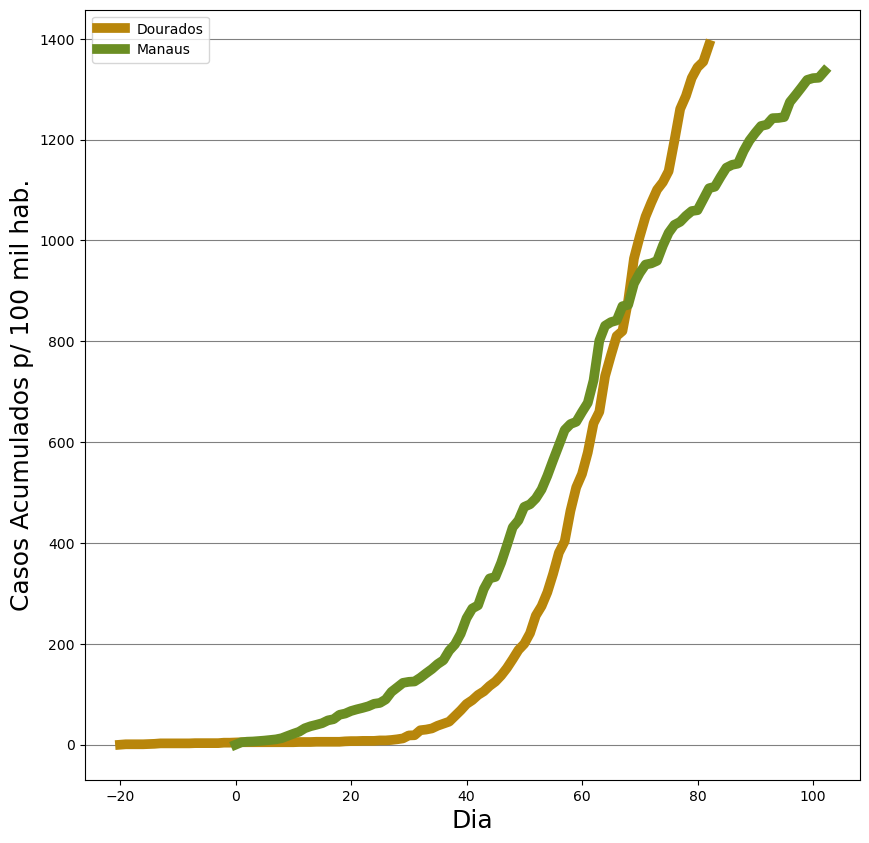

data início da reta ajustada 2020-05-25 00:00:00
data início da reta ajustada 2020-05-11 00:00:00


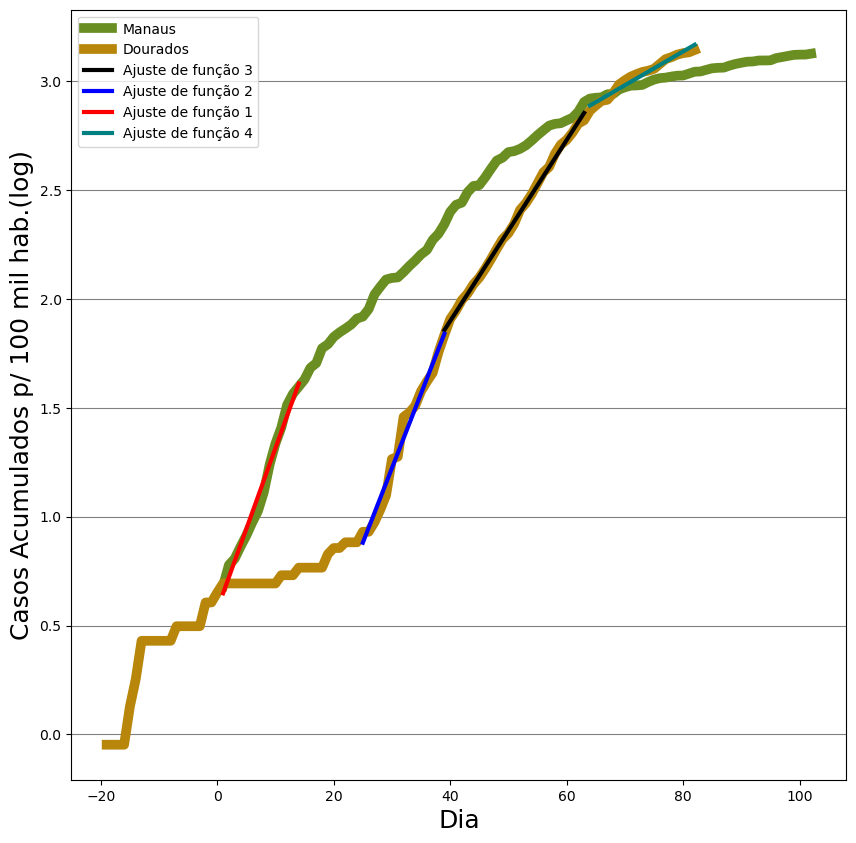


parâmetros da reta 3:  [0.04154188 0.23634966] 
 matriz de covariância:
 [[ 1.32470273e-07 -6.75598399e-06]
 [-6.75598399e-06  3.51443643e-04]]

parâmetros da reta 2:  [ 0.06850074 -0.83224762] 
 matriz de covariância:
 [[ 7.49010741e-06 -2.39683437e-04]
 [-2.39683437e-04  7.80968534e-03]]

parâmetros da reta 1:  [0.07410634 0.57384846] 
 matriz de covariância:
 [[ 7.00474659e-06 -5.25355993e-05]
 [-5.25355993e-05  5.07844127e-04]]
10**0.04154187504152085 = 1.1003779395530675


In [48]:
comp_cidades(df_cidade1, df_cidade2)

In [11]:

def editBarhPlot(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        valor = rect.get_width()
        
        if type(valor) == np.float64:
            valor = round(valor,1)
        ax.annotate('{}'.format(valor),
                    xy=( valor , rect.get_y()),
                    xytext=(3, 0),  # 3 points horisontal offset
                    textcoords="offset points",
                    ha='left', va='bottom')




def casos_est_muni(df_uf_muni, uf, pathfigs = './figs/'):
    df_uf_muni.sort_values('casosAcumulado',ascending = True, inplace=True)
    muni_leg = df_uf_muni['municipio'].unique().tolist()

    ### figura 01 - casos por município
    fig, ax = plt.subplots(figsize=(12,18))

    rec = ax.barh('municipio', 'casosAcumulado', data=df_uf_muni,  color= 'darkred' )
   
    ax.set_ylabel('Município',fontsize=20 )
    ax.set_xlabel('Número de Casos',fontsize=20  )
    #ax.set_title('Casos por município\n Estado do Mato Grosso do Sul', fontsize=25)
    
    #ax.legend()

    editBarhPlot(rec, ax)
    plt.savefig( pathfigs + 'casos_por_municipio' + '.png', format ='png',  bbox_inches='tight')
    plt.show()

    ### figura dois - casos por cem mil habitantes
    df_uf_muni.sort_values('CA_por_cemMil_Hab',ascending = True, inplace=True)

    fig, ax = plt.subplots(figsize=(12,18))
   
    rec = ax.barh('municipio', 'CA_por_cemMil_Hab', data=df_uf_muni, color= 'brown')
   
    ax.set_ylabel('Município',fontsize=20 )
    ax.set_xlabel('Número de Casos por 100 mil habitantes',fontsize=20  )
    #ax.set_title('Casos por 100 mil habitantes\n Estado do Mato Grosso do Sul', fontsize=25)
    
    #ax.legend()

    editBarhPlot(rec, ax)
    plt.savefig( pathfigs + 'casos_100_mil_por_municipio' + '.png', format ='png',  bbox_inches='tight')
    plt.show()

        ### figura três - população
    df_uf_muni.sort_values('populacaoTCU2019',ascending = True, inplace=True)

    fig, ax = plt.subplots(figsize=(12,18))
   
    rec = ax.barh('municipio', 'populacaoTCU2019', data=df_uf_muni, color= 'cadetblue')
   
    ax.set_ylabel('Município',fontsize=20 )
    ax.set_xlabel('População estimada (TCU 2019)',fontsize=20  )
    #ax.set_title('População por Município\n Estado do Mato Grosso do Sul', fontsize=25)
    
    #ax.legend()
    editBarhPlot(rec, ax)
    plt.savefig( pathfigs + 'pop_por_municipio' + '.png', format ='png',  bbox_inches='tight')
    plt.show()



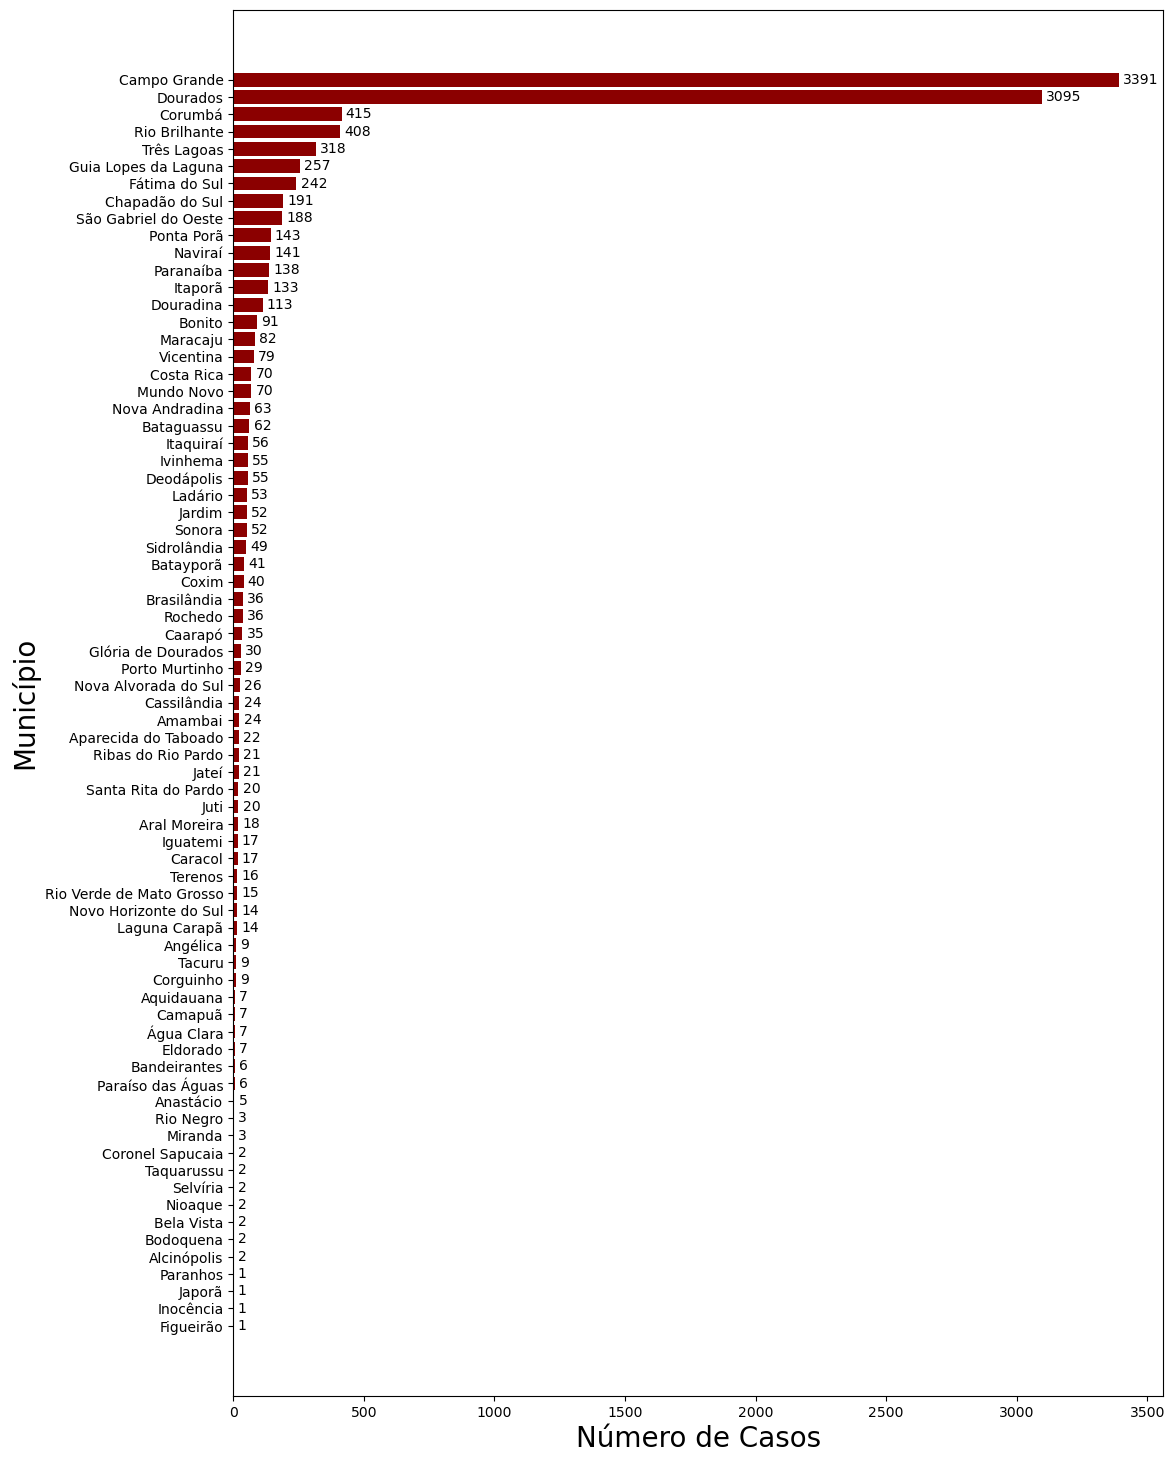

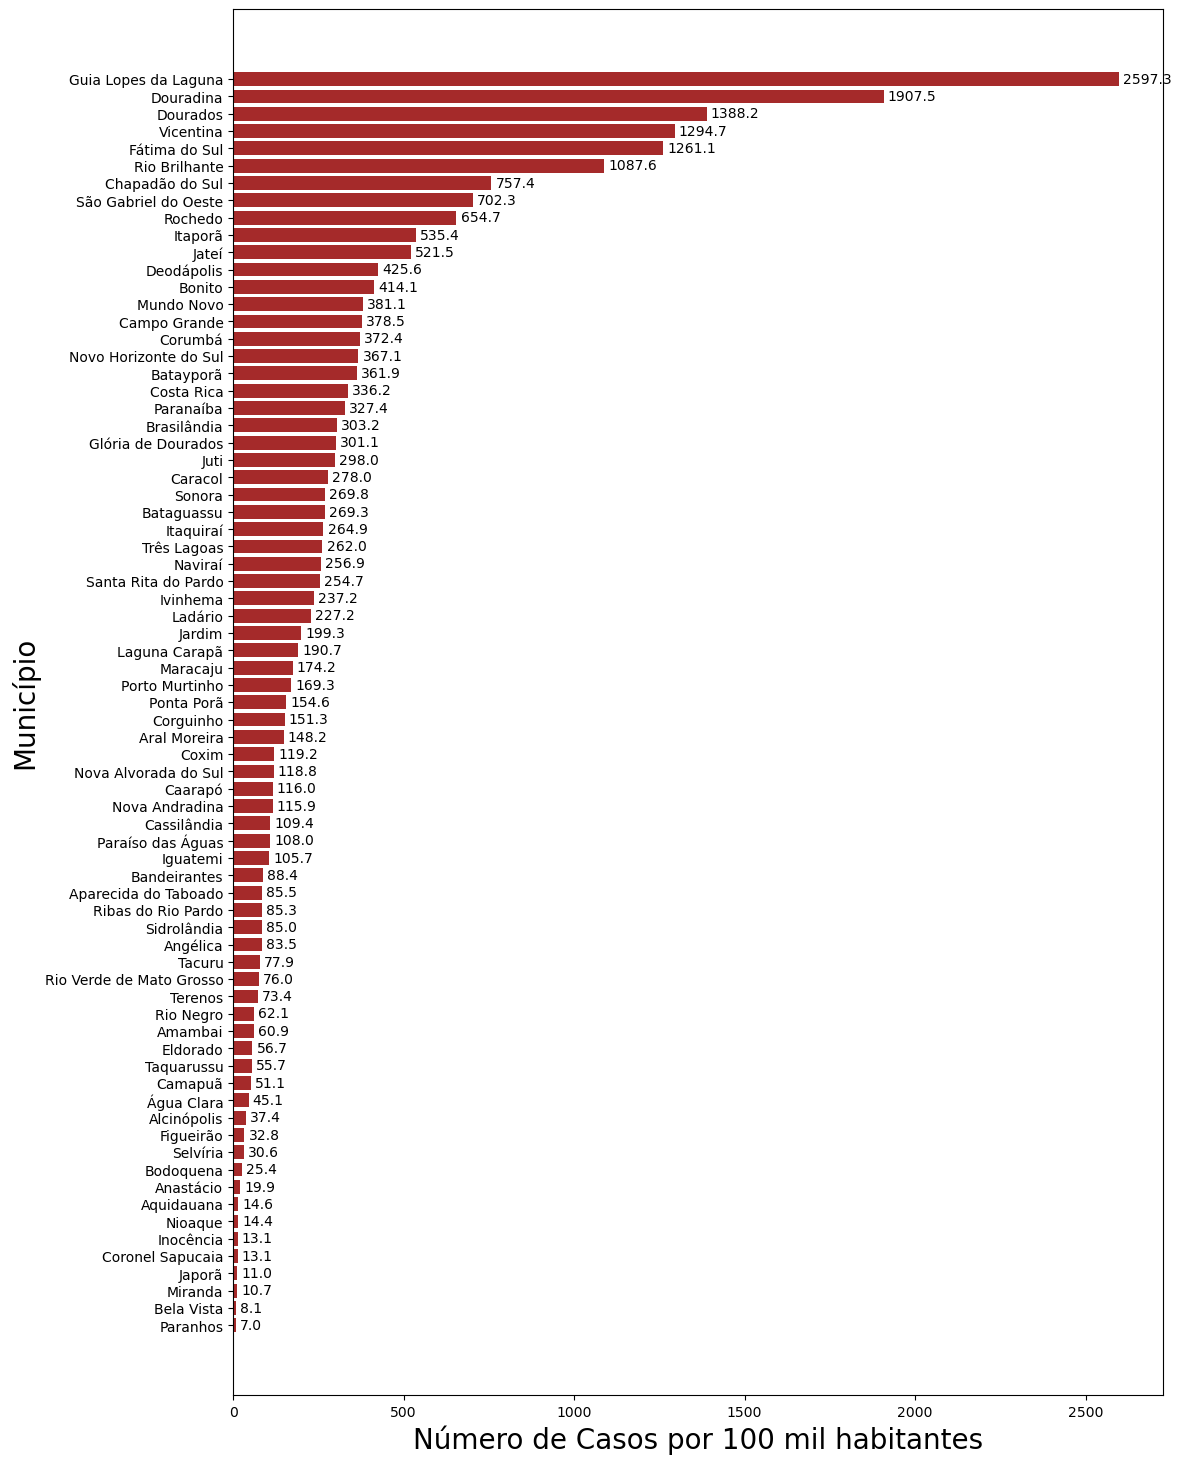

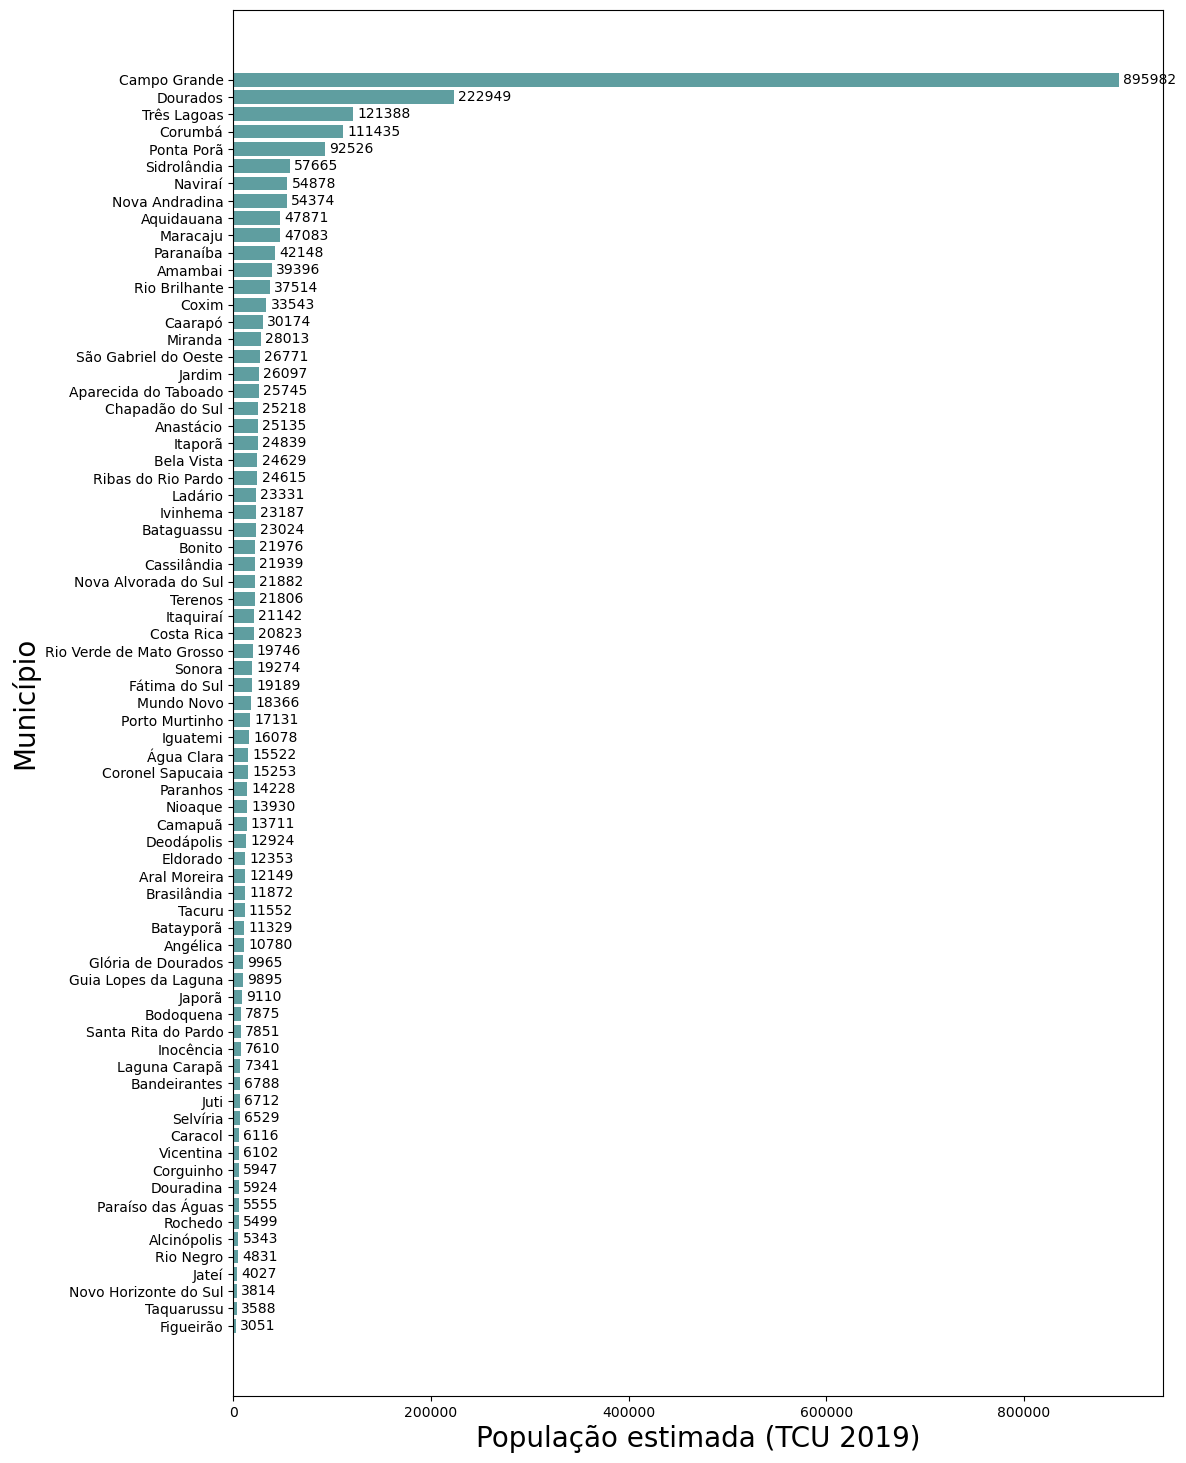

In [12]:
casos_est_muni(df_est1_muni, uf_list[0])

In [13]:
df_est1_muni

municipio  populacaoTCU2019  casosAcumulado  obitosAcumulado  \
29              Figueirão              3051               1                0   
68             Taquarussu              3588               2                0   
51  Novo Horizonte do Sul              3814              14                0   
40                  Jateí              4027              21                0   
59              Rio Negro              4831               3                0   
..                    ...               ...             ...              ...   
55             Ponta Porã             92526             143                4   
22                Corumbá            111435             415               12   
70            Três Lagoas            121388             318                7   
27               Dourados            222949            3095               36   
16           Campo Grande            895982            3391               24   

    CA_por_cemMil_Hab  OA_por_cemMil_Hab  CA_cemMil_log  OA_cemMil_log  
29          32.776139           0.000000       1.515558           -inf  
68          55.741360           0.000000       1.746178           -inf  
51         367.068694           0.000000       2.564747           -inf  
40         521.480010           0.000000       2.717238           -inf  
59          62.098944           0.000000       1.793084           -inf  
..                ...                ...            ...            ...  
55         154.551153           4.323109       2.189072       0.635796  
22         372.414412          10.768610       2.571026       1.032160  
70         261.969882           5.766633       2.418251       0.760922  
27        1388.209860          16.147191       3.142455       1.208097  
16         378.467425           2.678625       2.578029       0.427912  

[73 rows x 8 columns]

In [14]:
mapa = gpd.read_file('../data/geojsonDL/MS.json', driver='GeoJSON')
mapa.rename(columns={'NOME': 'municipio'}, inplace=True)


In [15]:
def mapa_estado_muni(df, df_geo, nLevels, pathfigs ='./figs/'):
    df1 = df.set_index('municipio')
    mapaPlot = df_geo.join(df1, on='municipio' , how= 'outer')
    mapaPlot.head()
    mapaPlot.dropna(inplace=True)

    mapaPlot['coords'] = mapaPlot['geometry'].apply(lambda x: x.representative_point().coords[:])
    mapaPlot['coords'] = [coords[0] for coords in mapaPlot['coords']]

    fig, ax1 = plt.subplots(1, 1, figsize=(15,15))

    geoplot.polyplot(df_geo, ax=ax1)
    casos_p_habitante = mapaPlot['CA_por_cemMil_Hab']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)

    #plt.title('Covid - Casos Diagnosticados em cada município por 100 mil habitantes', fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue= casos_p_habitante , scheme=scheme, ax=ax1,
        cmap='Oranges', legend=True, ec='k'
    )

    for idx, row in mapaPlot.iterrows():
        if row['municipio'] == 'Dourados':
            colorName = 'yellow'
            fontS = 12
        elif row['municipio'] == 'Campo Grande':
            colorName = 'darkslategray'
            fontS = 12
        else:
            colorName = 'k'
            fontS = 5

        plt.annotate(s=row['municipio'], xy=row['coords'], horizontalalignment='center', fontsize =fontS, color = colorName)
    plt.savefig( pathfigs + 'mapa_casos_100_mil' + '.png', format ='png',  bbox_inches='tight')
### figura 02 - casos caumulados
    fig, ax1 = plt.subplots(1, 1, figsize=(15,15))

    geoplot.polyplot(df_geo, ax=ax1)
    casos_tot = mapaPlot['casosAcumulado']
    scheme = mapclassify.Quantiles(casos_tot, k=nLevels)

    #plt.title('Covid - Casos Diagnosticados Totais', fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue= casos_tot , scheme=scheme, ax=ax1,
        cmap='Reds', legend=True, ec='k'
    )



    for idx, row in mapaPlot.iterrows():
        if row['municipio'] == 'Dourados':
            colorName = 'yellow'
            fontS = 12
        elif row['municipio'] == 'Campo Grande':
            colorName = 'darkslategray'
            fontS = 12
        else:
            colorName = 'k'
            fontS = 5

        plt.annotate(s=row['municipio'], xy=row['coords'], horizontalalignment='center', fontsize =fontS, color = colorName)
    plt.savefig( pathfigs + 'mapa_casos_registrados' + '.png', format ='png')

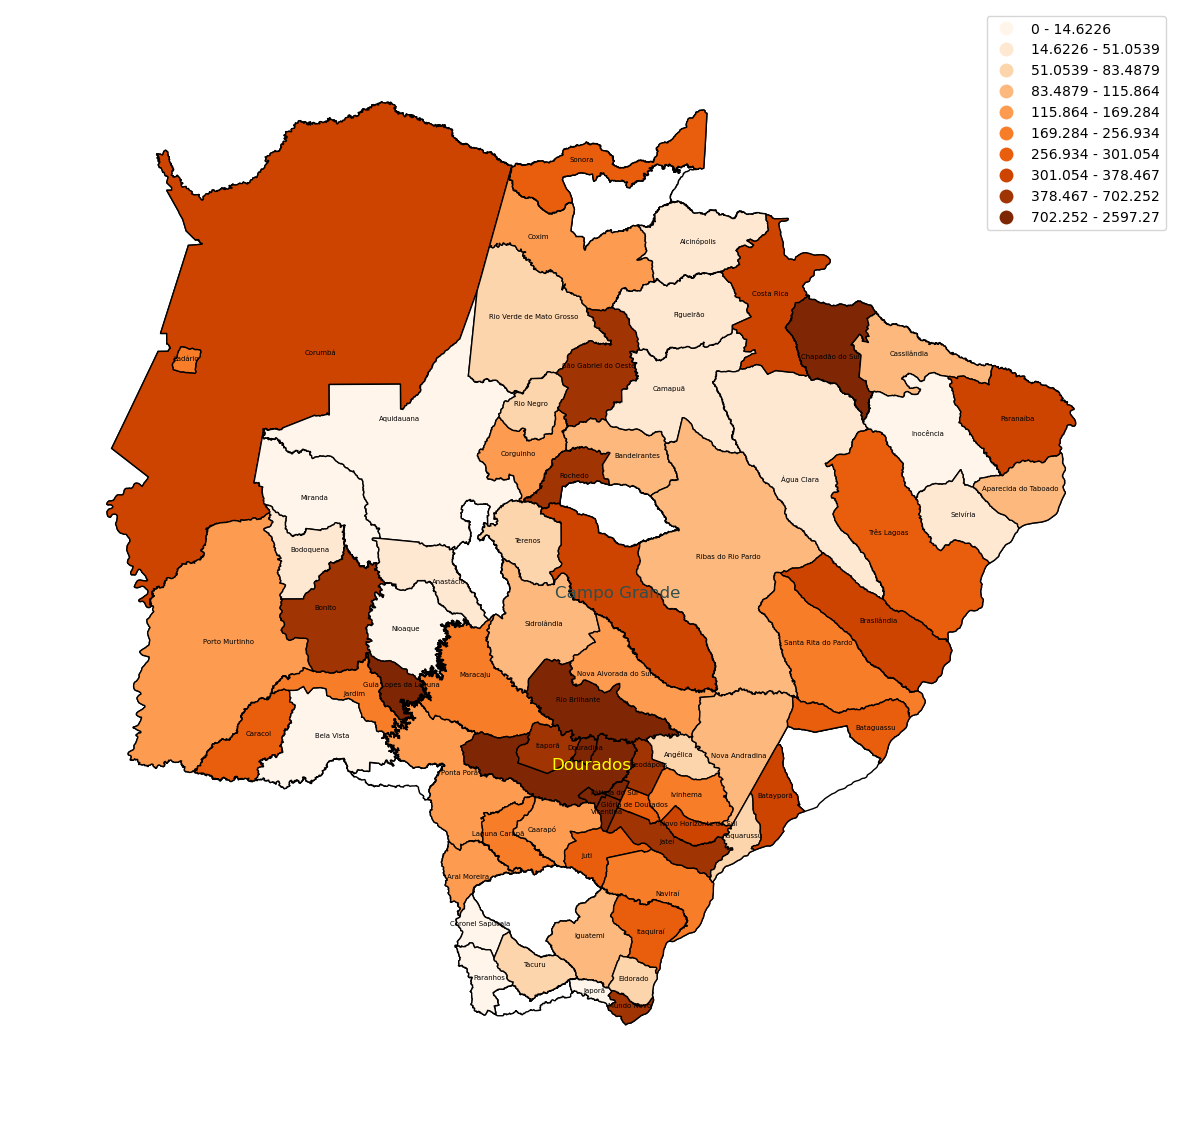

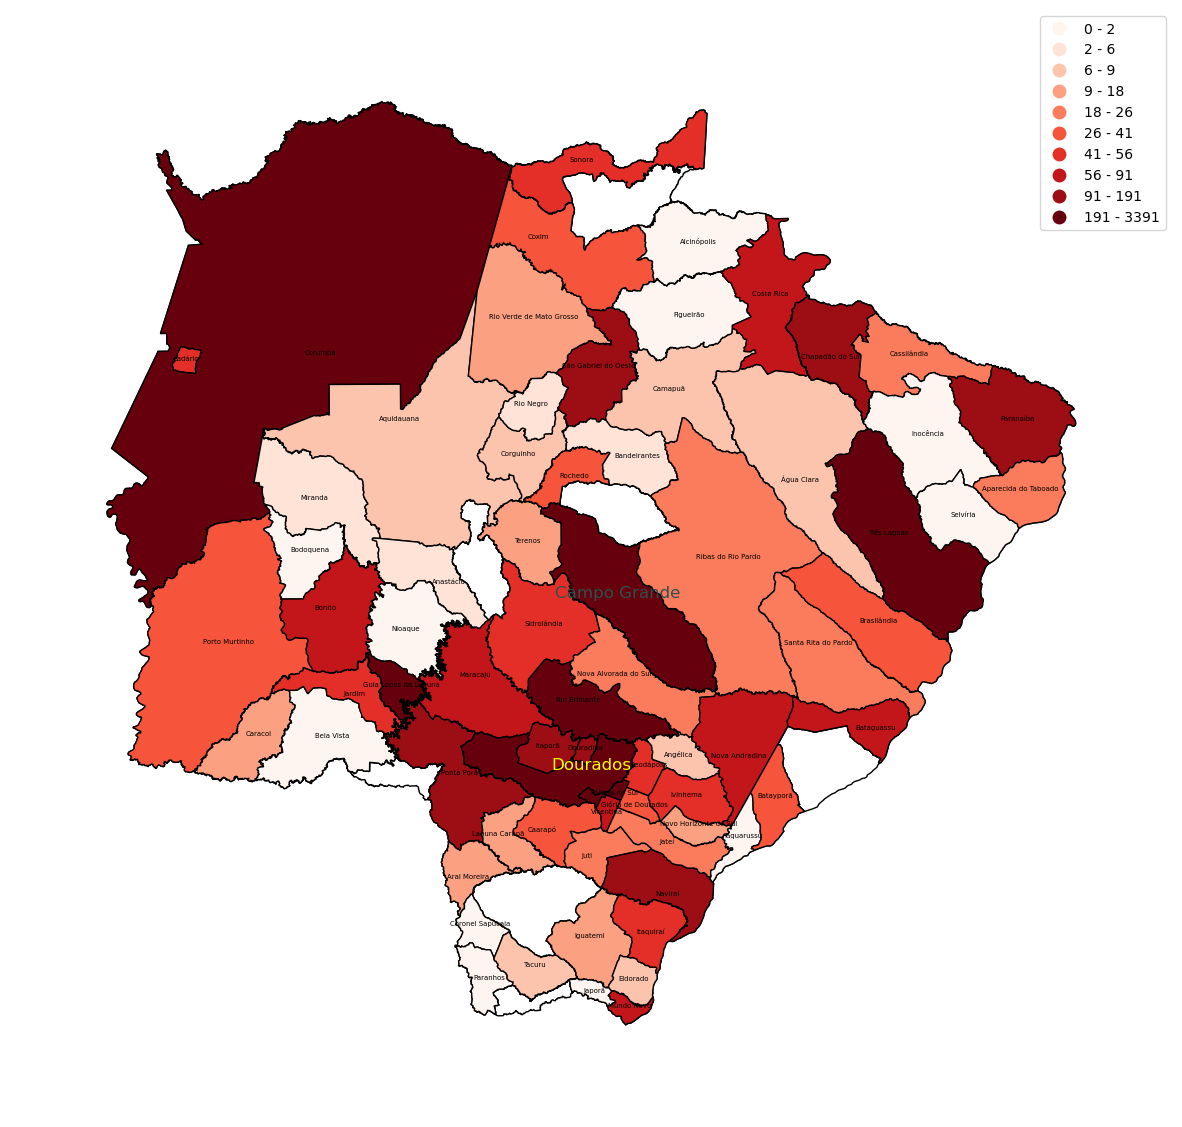

In [16]:
mapa_estado_muni(df_est1_muni, mapa, 10)

In [17]:
222949/895982

0.2488320077858707

## Casos acumulados no estado

In [18]:
casosTotMs =df_est1_muni.agg({'casosAcumulado': sum})
casosTotMs

casosAcumulado    10694
dtype: int64

### Proporção de casos de Dourados em relação ao estado

In [19]:
fltr = df_est1_muni['municipio'] == 'Dourados'
df_est1_muni.loc[fltr, :].agg({'casosAcumulado': sum})/casosTotMs

casosAcumulado    0.289415
dtype: float64

### Proporção de casos de Dourados em relação à Campo Grande

In [20]:
fltr = df_est1_muni['municipio'].isin(['Dourados', 'Campo Grande'])
doucampG = df_est1_muni.loc[fltr, :]
print('\n',doucampG.head())
print('\nProporção de casos Dourados/ Campo Grande')
print(doucampG.iloc[0,2]/doucampG.iloc[1,2])


        municipio  populacaoTCU2019  casosAcumulado  obitosAcumulado  \
27      Dourados            222949            3095               36   
16  Campo Grande            895982            3391               24   

    CA_por_cemMil_Hab  OA_por_cemMil_Hab  CA_cemMil_log  OA_cemMil_log  
27        1388.209860          16.147191       3.142455       1.208097  
16         378.467425           2.678625       2.578029       0.427912  

Proporção de casos Dourados/ Campo Grande
0.9127101150103214


### Casos Acumulados no entrono imediado de Dourados

In [21]:
divisas = ['Maracaju', 'Rio Brilhante', 'Itaporã', 'Douradina', 'Deodápolis', 'Fátima do Sul', 'Caarapó', 'Laguna Carapã', 'Ponta Porã']
fltr = df_est1_muni['municipio'].isin(divisas + ['Dourados'])
df_divisas = df_est1_muni.loc[fltr, :]
print(df_divisas.shape)
entornoDoucasos = df_divisas.agg({'casosAcumulado': sum})
entornoDoucasos

(10, 8)


casosAcumulado    4320
dtype: int64

In [22]:
entornoDoucasos/casosTotMs

casosAcumulado    0.403965
dtype: float64

### Considerando Vicentina e Glória de Dourados

In [23]:
prox2 = ['Vicentina', 'Glória de Dourados']
fltr = df_est1_muni['municipio'].isin(divisas + ['Dourados'] + prox2)
entornoExp = df_est1_muni.loc[fltr, :].agg({'casosAcumulado': sum})
entornoExp

casosAcumulado    4429
dtype: int64

In [24]:
entornoExp/casosTotMs

casosAcumulado    0.414157
dtype: float64

In [25]:
df_bolet['testes totais'] = df_bolet['TESTES CONFIRMADOS'] + df_bolet['TESTES DESCARTADOS']

In [26]:
df_bolet['percent_posit'] = df_bolet['TESTES CONFIRMADOS']/ df_bolet['testes totais']

In [27]:
df_bolet.head(30)

DOURADOS JUNHO   CASOS  ÓBITOS  ÓBITOS DE OUTRAS LOCALIDADES  \
0              1.0   307.0     2.0                           2.0   
1              2.0   339.0     2.0                           2.0   
2              3.0   378.0     2.0                           2.0   
3              4.0   414.0     2.0                           2.0   
4              5.0   446.0     2.0                           2.0   
5              6.0   493.0     2.0                           2.0   
6              7.0   571.0     2.0                           2.0   
7              8.0   613.0     2.0                           2.0   
8              9.0   674.0     2.0                           2.0   
9             10.0   756.0     2.0                           2.0   
10            11.0   849.0     2.0                           2.0   
11            12.0   899.0     2.0                           2.0   
12            13.0  1034.0     2.0                           2.0   
13            14.0  1138.0     4.0                           5.0   
14            15.0  1197.0     6.0                           6.0   
15            16.0  1292.0     5.0                           6.0   
16            17.0  1421.0     5.0                           6.0   
17            18.0  1472.0     7.0                           6.0   
18            19.0  1630.0     9.0                           6.0   
19            20.0  1721.0    10.0                           7.0   
20            21.0  1807.0    10.0                           7.0   
21            22.0  1829.0    11.0                           7.0   
22            23.0  1964.0    13.0                           8.0   
23            24.0  2150.0    13.0                           8.0   
24            25.0  2247.0    15.0                           9.0   
25            26.0  2335.0    19.0                           9.0   
26            27.0  2397.0    21.0                          10.0   
27            28.0  2454.0    22.0                          10.0   
28            29.0  2487.0    22.0                          10.0   
29            30.0  2536.0    22.0                          11.0   

    TOTAL TESTES REALIZADOS  diferença testagem dia anterior  \
0                       NaN                              NaN   
1                    1586.0                              NaN   
2                    1705.0                              NaN   
3                       NaN                              NaN   
4                    1820.0                              NaN   
5                    1949.0                              NaN   
6                    2134.0                              NaN   
7                    2262.0                              NaN   
8                    2452.0                              NaN   
9                    2724.0                              NaN   
10                   3016.0                              NaN   
11                      NaN                              NaN   
12                      NaN                              NaN   
13                   4072.0                              NaN   
14                   4257.0                              NaN   
15                      NaN                              NaN   
16                      NaN                              NaN   
17                   4904.0                              NaN   
18                      NaN                              NaN   
19                   4481.0                              NaN   
20                   7182.0                              NaN   
21                   5629.0                              NaN   
22                   5841.0                            212.0   
23                   6170.0                            329.0   
24                   6358.0                            188.0   
25                   6567.0                            209.0   
26                   6792.0                            225.0   
27                   6829.0                             37.0   
28                   6983.0            

Text(0.5, 1.0, 'Testes em Dourados: mês de Junho')

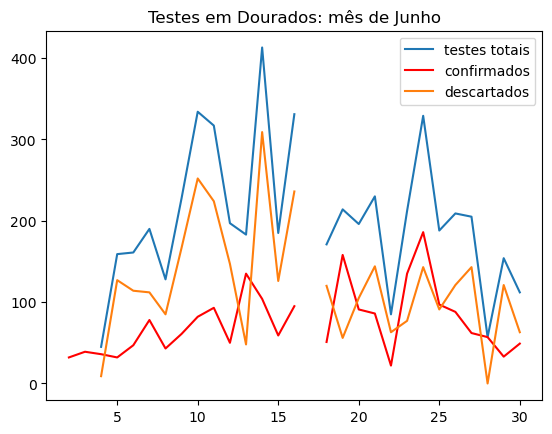

In [28]:
plt.plot(df_bolet['DOURADOS JUNHO'],df_bolet['testes totais'] , label = 'testes totais')
plt.plot(df_bolet['DOURADOS JUNHO'],df_bolet['TESTES CONFIRMADOS'] , label = 'confirmados', color = 'red')
plt.plot(df_bolet['DOURADOS JUNHO'],df_bolet['TESTES DESCARTADOS'], label = 'descartados' )
plt.legend()
plt.title('Testes em Dourados: mês de Junho')


In [29]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff


In [30]:
trace1 = go.Bar( x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['testes totais'], name = 'testes totais')
trace2 = go.Bar( x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['TESTES CONFIRMADOS'], name = 'confirmados')
trace3 = go.Bar(x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['TESTES DESCARTADOS'], name = 'descartados')
data = [ trace1, trace2, trace3]
layout = go.Layout(barmode= 'group', margin= dict(b=0, l=0, r=0, t=10), width= 800)
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'teste-plotly')

In [31]:
trace1 = go.Scatter( x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['percent_posit'], name = "taxa de positivos",
marker=dict(color = 'yellow'))
trace2 = go.Bar( x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['percent_posit'], name = "taxa de positivos")
data = [trace1, trace2]
layout = go.Layout( margin= dict(b=50, l=0, r=0, t=10), width= 800)
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'teste-plotly')

In [32]:
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']

trace1 = go.Scatter( x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['percent_posit']*100, name = "% de positivos" )

trace2 = go.Bar( x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['TESTES CONFIRMADOS'], name = "confirmados")
trace3 = go.Bar( x= df_bolet['DOURADOS JUNHO'], y =  df_bolet['TESTES DESCARTADOS'], name = 'descartados')
data = [trace1, trace2, trace3]
layout = go.Layout(barmode= 'stack', template = "plotly", margin= dict(b=50, l=0, r=0, t=10), width= 800)

fig = go.Figure(data = data, layout = layout)

iplot(fig, filename = 'teste-plotly')

In [33]:
trace1 = go.Box(
            y=df_bolet['percent_posit'].head(15),
            name= 'Junho 1', boxpoints='all'
          )
trace2 = go.Box(
            y=df_bolet['percent_posit'].tail(17),
            name= 'Junho 2', boxpoints='all'
          )

layout = go.Layout(
    title='Percentual de positivos',
    
    margin=dict(
        l=30,
        r=30,
        b=80,
        t=100,
    ),
    template = 'plotly_white',
    #paper_bgcolor='rgb(243, 243, 243)',
    #plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)

fig = go.Figure(data=[trace1, trace2], layout = layout)
iplot(fig)

In [34]:
trace1 = go.Box(
            y = df_bolet['testes totais'].head(15),
            name= 'Junho 1',
             boxpoints='all', hovertext= 'Dia :' + df_bolet['DOURADOS JUNHO'].head(15).astype(str)
            
          )


trace2 = go.Box(
            y=df_bolet['testes totais'].tail(17),
            name= 'Junho 2', boxpoints='all',
            hovertext= 'Dia :' + df_bolet['DOURADOS JUNHO'].tail(17).astype(str)
            
          )

layout = go.Layout(
    title='Testes Totais',
    
    margin=dict(
        l=30,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)



fig = go.Figure(data=[trace1, trace2], layout = layout)
iplot(fig)

In [35]:
df_bolet[['DOURADOS JUNHO','testes totais']].head(15)

DOURADOS JUNHO  testes totais
0              1.0            NaN
1              2.0            NaN
2              3.0            NaN
3              4.0           45.0
4              5.0          159.0
5              6.0          161.0
6              7.0          190.0
7              8.0          128.0
8              9.0          228.0
9             10.0          334.0
10            11.0          317.0
11            12.0          197.0
12            13.0          183.0
13            14.0          413.0
14            15.0          185.0

In [36]:
df_bolet[['DOURADOS JUNHO','testes totais']].tail(17)

DOURADOS JUNHO  testes totais
15            16.0          331.0
16            17.0            NaN
17            18.0          171.0
18            19.0          214.0
19            20.0          196.0
20            21.0          230.0
21            22.0           85.0
22            23.0          212.0
23            24.0          329.0
24            25.0          188.0
25            26.0          209.0
26            27.0          205.0
27            28.0           57.0
28            29.0          154.0
29            30.0          112.0
30             NaN            NaN
31             NaN            NaN

In [37]:
df_bolet.shape

(32, 12)